In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os.path
import cv2

In [2]:
#the random seed and generation of random values
np.random.seed(42)
def generateValues(mean,covariance,size):
    setValue = np.random.multivariate_normal(mean,covariance,size)
    return setValue

#math to find gi for case 1
def discriminateValue(xy,meanValue,covariance,prior):
    mean = np.matrix([[meanValue[0],meanValue[1]]])
    temp = xy-mean
    info1 = temp*np.linalg.inv(covariance)*temp.transpose()*(-1/2) + math.log(prior)
    return info1

In [3]:
#case 1 decision boundary calculation
def case1DecisionBoundary(mean1,mean2,covariance1,prior1,prior2):
    newMean1 = np.matrix([[mean1[0],mean1[1]]])
    newMean2 = np.matrix([[mean2[0],mean2[1]]])

    testInitial = (newMean1-newMean2)

    xInitial = 1/2 * (newMean1+newMean2)
    xInitial2 = (newMean1-newMean2)

    temp = covariance1/(xInitial2*xInitial2.transpose())
    temp = temp * (math.log(prior1/prior2)) * xInitial2.transpose()
    temp = temp.transpose()
    xInitial = xInitial - temp

    xInitial = xInitial*xInitial2.transpose()

    xStart = 0
    yStart = xInitial/testInitial[0,1]

    yEnd = 0
    xEnd = xInitial/testInitial[0,0]

    slope = yStart/xEnd

    return xStart,yStart,xEnd,yEnd,slope

In [4]:
#the math to find gi for case 3 
def discriminateValueCase3(xy,meanValue,covariance,prior):
    mean = np.matrix([[meanValue[0],meanValue[1]]])
    firstW = -1/2 * np.linalg.inv(covariance) 
    
    firstW = xy * firstW * xy.transpose()
    
    secondW = np.linalg.inv(covariance) * mean.transpose()
    secondW = secondW.transpose() * xy.transpose()
    
    initialW = -1/2 * mean * np.linalg.inv(covariance) * mean.transpose()
    initialW = initialW - (1/2 * math.log(np.linalg.det(covariance))) + math.log(prior)
    
    info = firstW + secondW + initialW
    
    return info

In [5]:
#case 3 decision boundary calculation
def decisionBoundaryCase3(meanValue1,meanValue2,covariance1,covariance2,prior1,prior2):
    mean1 = np.matrix([[meanValue1[0],meanValue1[1]]])
    mean2 = np.matrix([[meanValue2[0],meanValue2[1]]])
    
    initialW1 = -1/2 * mean1 * np.linalg.inv(covariance1) * mean1.transpose()
    initialW1 = initialW1 - (1/2 * math.log(np.linalg.det(covariance1))) + math.log(prior1)
    
    initialW2 = -1/2 * mean2 * np.linalg.inv(covariance2) * mean2.transpose()
    initialW2 = initialW2 - (1/2 * math.log(np.linalg.det(covariance2))) + math.log(prior2)
    
    zeroValue = -(initialW1 - initialW2)
    
    secondW1 = np.linalg.inv(covariance1) * mean1.transpose()
    secondW1 = secondW1.transpose()
    
    secondW2 = np.linalg.inv(covariance2) * mean2.transpose()
    secondW2 = secondW2.transpose()
    secondW = secondW1 - secondW2
    
    firstW1 = -1/2 * np.linalg.inv(covariance1) 
    firstW2 = -1/2 * np.linalg.inv(covariance2) 
    
    firstW = firstW1 - firstW2
    firstW = [[1,1]] * firstW 
    
    x1 = math.sqrt(zeroValue[0,0]/firstW[0,0])
    x2 = -math.sqrt(zeroValue[0,0]/firstW[0,0])

    
    return x1,x2

In [6]:
#class to find allthe miss classification information
def missClassification(setA,column):
    countOf0 = 0
    countOf1 = 0
    for x in range(setA.shape[0]):
        actual = setA[x][2]
        classified = setA[x][column]
        if actual != classified and actual == 0:
            countOf0 = countOf0 + 1
        elif actual != classified and actual == 1:
            countOf1 = countOf1 + 1

    countOf = np.count_nonzero(setA < 1, axis = 0)
    missClassification0 = countOf0/countOf[column]
    missClassification1 = countOf1/(setA.shape[0]-countOf[column])
    totalMissClassification = (countOf0+countOf1)/setA.shape[0]

    return missClassification0, missClassification1, totalMissClassification

In [7]:
#class to calculate the bhattacharyya Error
def bhattacharyyaError(mean1,mean2,covariance1,covariance2,prior1,prior2):
    newMean1 = np.matrix([[mean1[0],mean1[1]]])
    newMean2 = np.matrix([[mean2[0],mean2[1]]])
    segment1 = 1/8 * (newMean2 - newMean1)
    
    covarianceValue = (covariance1 + covariance2)/2
    
    segment1 = segment1 * np.linalg.inv(covarianceValue)
    segment1 = segment1 * (newMean2-newMean1).transpose()
    
    segment2Denom = math.sqrt(np.linalg.det(covariance1) * np.linalg.det(covariance2))
    segment2 = 1/2 * math.log(np.linalg.det(covarianceValue)/segment2Denom)
    
    k = segment1 + segment2
    
    error = math.sqrt(prior1*prior2) * math.exp(-k[0,0])
    
    return (error)


In [8]:
path = os.path.join(os.getcwd(), 'dataSet1.npy')

if os.path.isfile(path):
    mean1 = [1,1]
    covariance1 = np.matrix([[1,0],[0,1]])
    mean2 = [4,4]
    covariance2 = np.matrix([[1,0],[0,1]])
    with open(path,'rb') as f:
        setA = np.load(f)
else:
    #generates the data 
    mean1 = [1,1]
    covariance1 = np.matrix([[1,0],[0,1]])
    setA1 = generateValues(mean1,covariance1,60000)
    classifier = np.zeros((60000,1))
    setA1 = np.hstack((setA1,classifier))

    mean2 = [4,4]
    covariance2 = np.matrix([[1,0],[0,1]])
    setA2 = generateValues(mean2,covariance2,140000)
    classifier = np.ones((140000,1))
    setA2 = np.hstack((setA2,classifier))

    #combines the 2 data sets and calculate prior
    setA = np.concatenate((setA1,setA2))
    bayesClassifier = np.ones((200000,1))
    euclideanClassifier = np.ones((200000,1))
    setA = np.hstack((setA,bayesClassifier))
    setA = np.hstack((setA,euclideanClassifier))
    with open(path,'wb') as f:
        np.save(f, setA)


prior1 = 60000/setA.shape[0]
prior2 = 140000/setA.shape[0]

#for each value calculate g1 and g2 and classify by each
for x in range(setA.shape[0]):
    
    classifierValue = np.matrix([[setA[x][0],setA[x][1]]])
    value1 = discriminateValue(classifierValue,mean1,covariance1,prior1)
    
    value2 = discriminateValue(classifierValue,mean2,covariance1,prior2)
    
    classValue = 0

    if value1<value2:
        classValue = 1

    setA[x,3] = classValue

#sorts by the new classified data
newSet = setA[setA[:,3].argsort()]
temp = np.count_nonzero(newSet < 1, axis = 0)
zeroes = temp[3]

#finds the decision boundary
xStart,yStart,xEnd,yEnd,slope = case1DecisionBoundary(mean1,mean2,covariance1,prior1,prior2)

#calculates the miss classification
missClassification0, missClassification1, totalMissClassification = missClassification(setA,3)
error = bhattacharyyaError(mean1,mean2,covariance1,covariance2,prior1,prior2)

print("class 1 misclassification ",missClassification0)
print("class 2 misclassification ",missClassification1)
print("total misclassification ",totalMissClassification)
print("Bhattacharyya Error = ", error)

#plots the data sets with the decision boundary
#fig1 , axis1 = plt.subplots(1,2)
#
#axis1[0].scatter(setA[:60000,0],setA[:60000,1], s=5, alpha = .5)
#axis1[0].scatter(setA[60000:,0],setA[60000:,1], s=5, alpha = .5)
#axis1[0].set_title("Original Data")
#
#axis1[1].scatter(newSet[:zeroes,0],newSet[:zeroes,1], s=5, alpha = .5)
#axis1[1].scatter(newSet[zeroes:,0],newSet[zeroes:,1], s=5, alpha = .5)
#axis1[1].axline((xStart,yStart[0,0]),(xEnd[0,0],yEnd),color = 'r',label = 'HyperPlane')
#axis1[1].set_title("Predicted data")
#plt.show()

class 1 misclassification  0.027563469616588288
class 2 misclassification  0.009982388215077685
total misclassification  0.015235
Bhattacharyya Error =  0.04829999247443921


In [9]:
path = os.path.join(os.getcwd(), 'dataSet2.npy')
if os.path.isfile(path):
    meanB1 = [1,1]
    meanBCov1 = np.matrix([[1,0],[0,1]])
    meanB2 = [4,4]
    meanBCov2 = np.matrix([[4,0],[0,8]])
    with open(path,'rb') as f:
        setB = np.load(f)
else:
    #create the distribution of setB of data
    meanB1 = [1,1]
    meanBCov1 = np.matrix([[1,0],[0,1]])
    setB1 = generateValues(meanB1,meanBCov1,60000)
    classifier = np.zeros((60000,1))
    setB1 = np.hstack((setB1,classifier))

    meanB2 = [4,4]
    meanBCov2 = np.matrix([[4,0],[0,8]])
    setB2 = generateValues(meanB2,meanBCov2,140000)
    classifier = np.ones((140000,1))
    setB2 = np.hstack((setB2,classifier))

    #combine the 2 sets of data and adds a new row for classifier data
    setB = np.concatenate((setB1,setB2))
    setB = np.hstack((setB,bayesClassifier))
    setB = np.hstack((setB,euclideanClassifier))
    with open(path,'wb') as f:
        np.save(f, setB)

#calculates the prior
priorB1 = 60000/setB.shape[0]
priorB2 = 140000/setB.shape[0]

#for each value in the numpy, it checks value of g1 against g2 and classifies by largest result
for x in range(setB.shape[0]):
    classifierValue = np.matrix([[setB[x][0],setB[x][1]]])
    value1 = discriminateValueCase3(classifierValue,meanB1,meanBCov1,priorB1)
    value2 = discriminateValueCase3(classifierValue,meanB2,meanBCov2,priorB2)
    
    classValue = 0

    if value1<value2:
        classValue = 1

    setB[x,3] = classValue
    
#organizes by classified data for graph
newSetB = setB[setB[:,3].argsort()]

temp = np.count_nonzero(newSetB < 1, axis = 0)
zeroes = temp[3]

#calculates the decision boundary
point1,point2 = decisionBoundaryCase3(meanB1,meanB2,meanBCov1,meanBCov2,prior1,prior2)
circle = plt.Circle(((point1+point2)/2,(point1+point2)/2),radius = point1,fill = False)

#calculates the miss classification rates
missClassification0, missClassification1, totalMissClassification = missClassification(setB,3)
error = bhattacharyyaError(meanB1,meanB2,meanBCov1,meanBCov2,prior1,prior2)

#prints the classification errors
print("class 1 misclassification ",missClassification0)
print("class 2 misclassification ",missClassification1)
print("total misclassification ",totalMissClassification)
print("Bhattacharyya Error = ", error)

#plots the 2 data sets with the decision boundary
#fig, axis = plt.subplots(1,2)
#
#axis[0].scatter(setB[60000:,0],setB[60000:,1], s=5, alpha = .5)
#axis[0].scatter(setB[:60000,0],setB[:60000,1], s=5, alpha = .5)
#axis[0].set_title("Original Data")
#
#axis[1].scatter(newSetB[zeroes:,0],newSetB[zeroes:,1], s=5, alpha = .5)
#axis[1].scatter(newSetB[:zeroes,0],newSetB[:zeroes,1], s=5, alpha = .5) 
#axis[1].add_patch(circle)
#axis[1].set_title("Predicted Data")
#plt.show()

class 1 misclassification  0.07630595872374303
class 2 misclassification  0.07647530515874194
total misclassification  0.07642
Bhattacharyya Error =  0.16136700681940294


In [10]:
#classifier using the euclidean distance classifier
def euclideanClassifier(xy,meanValue):
    mean = np.matrix([[meanValue[0],meanValue[1]]])
    temp = xy-mean
    info1 = - temp*temp.transpose()
    return info1

In [11]:
#applying the euclidean classifier to a new column in setA
for x in range(setA.shape[0]):
    
    classifierValue = np.matrix([[setA[x][0],setA[x][1]]])
    value1 = euclideanClassifier(classifierValue,mean1)
    
    value2 = euclideanClassifier(classifierValue,mean2)
    
    classValue = 0

    if value1<value2:
        classValue = 1

    setA[x,4] = classValue

In [12]:
#applying the euclidean classifier to a new column in setB
for x in range(setB.shape[0]):
    
    classifierValue = np.matrix([[setB[x][0],setB[x][1]]])
    value1 = euclideanClassifier(classifierValue,meanB1)
    
    value2 = euclideanClassifier(classifierValue,meanB2)
    
    classValue = 0

    if value1<value2:
        classValue = 1

    setB[x,4] = classValue

In [13]:
#printing the classification error rate in setA with euclidean classifier
#EmissClassification0, EmissClassification1, EtotalMissClassification = missClassification(setA,4)
#print("class 1 misclassification ",EmissClassification0)
#print("class 2 misclassification ",EmissClassification1)
#print("total misclassification ",EtotalMissClassification)

In [14]:
#printing the classification error rate in setB with euclidean classifier
#E2missClassification0, E2missClassification1, E2totalMissClassification = missClassification(setB,4)
#print("class 1 misclassification ",E2missClassification0)
#print("class 2 misclassification ",E2missClassification1)
#print("total misclassification ",E2totalMissClassification)

In [15]:
def mlKnowns(set):
    means = np.mean(set[:,:2],axis=0)
    cov = np.cov(set[0:2])
    return means,cov

    


In [16]:
setA1Mean,setA1Covariance = mlKnowns(setA[:60000])
setA2Mean,setA2Covariance = mlKnowns(setA[60000:])

setB1Mean,setB1Covariance = mlKnowns(setB[:60000])
setB2Mean,setB2Covariance = mlKnowns(setB[60000:])

MLClassifier = np.ones((200000,1))
setA = np.hstack((setA,MLClassifier))
setB = np.hstack((setB,MLClassifier))

In [17]:
#data preprocessing 
#setA1Mean = [setA1Mean[0],setA1Mean[1]]
#setA2Mean = [setA2Mean[0],setA2Mean[1]]
#setB1Mean = [setB1Mean[0],setB1Mean[1]]
#setB2Mean = [setB2Mean[0],setB2Mean[1]]

#set the dialoginals to 0 
setA1Covariance[0,1] = 0
setA1Covariance[1,0] = 0
setA2Covariance[0,1] = 0
setA2Covariance[1,0] = 0

print(setA1Covariance)
print(setA1Mean)
print(setA2Covariance)
print(setA2Mean)

[[0.46757113 0.        ]
 [0.         1.4003947 ]]
[1.0068001  0.99751585]
[[2.89512242 0.        ]
 [0.         2.77175081]]
[4.00006567 3.99830645]


In [18]:
for x in range(setA.shape[0]):
    
    classifierValue = np.matrix([[setA[x][0],setA[x][1]]])
    value1 = discriminateValueCase3(classifierValue,setA1Mean,setA1Covariance, prior1)
    
    value2 = discriminateValueCase3(classifierValue,setA2Mean,setA2Covariance, prior2)
    
    classValue = 0

    if value1<value2:
        classValue = 1

    setA[x,5] = classValue

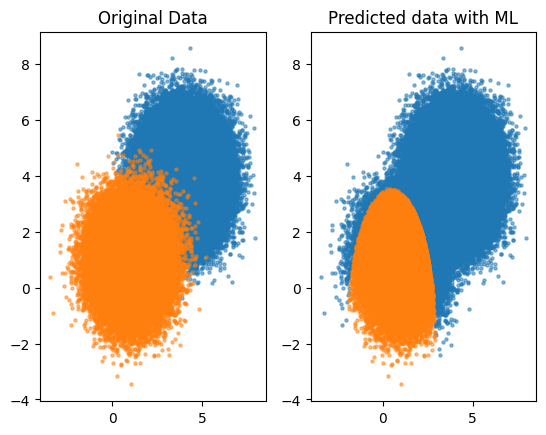

In [19]:
mlSetA = setA[setA[:,5].argsort()]
fig1 , axis1 = plt.subplots(1,2)
MLtemp = np.count_nonzero(mlSetA < 1, axis = 0)
MLzeroes = MLtemp[5]

axis1[0].scatter(setA[60000:,0],setA[60000:,1], s=5, alpha = .5)
axis1[0].scatter(setA[:60000,0],setA[:60000,1], s=5, alpha = .5)
axis1[0].set_title("Original Data")

axis1[1].scatter(mlSetA[MLzeroes:,0],mlSetA[MLzeroes:,1], s=5, alpha = .5)
axis1[1].scatter(mlSetA[:MLzeroes,0],mlSetA[:MLzeroes,1], s=5, alpha = .5)
axis1[1].set_title("Predicted data with ML")
plt.show()

In [20]:
MLerror1, MLerror2, MLerror = missClassification(setA,5)
print("class 1 misclassification ",MLerror1)
print("class 2 misclassification ",MLerror2)
print("total misclassification ",MLerror)

class 1 misclassification  0.11270947922223654
class 2 misclassification  0.0033507508291048416
total misclassification  0.033075


In [21]:
'''
add 4 more classifier columns, 
Column 6 = .01%
Column 7 = .1%
Column 8 = 1%
Column 9 = 10%
'''
for x in range(4):
    MLClassifier = np.ones((200000,1))
    setA = np.hstack((setA,MLClassifier))
    setB = np.hstack((setB,MLClassifier))

In [22]:
#Calculates the means and covariance given a smaller data set 

def parameterCalculations(set,size1,size2):
    np.random.seed(42)
    set1Mean1,set1Covariance1 = mlKnowns(set[:60000][np.random.choice(set[:60000].shape[0],size1,replace=True)])
    #np.random.seed(42)
    set2Mean1,set2Covariance1 = mlKnowns(set[60000:][np.random.choice(set[60000:].shape[0],size2,replace=True)])

    set1Covariance1[0,1] = set1Covariance1[1,0] = 0
    set2Covariance1[0,1] = set2Covariance1[1,0] = 0

    print(set1Mean1)
    print(set1Covariance1)

    print(set2Mean1)
    print(set2Covariance1)
    print()
    return set1Mean1,set1Covariance1,set2Mean1,set2Covariance1


In [23]:
for y in range(4):
    setA1Mean1, setA1Covariance1, setA2Mean1, setA2Covariance1 = parameterCalculations(setA,6*(10**(y)),14*(10**(y)))
    for x in range(setA.shape[0]):
        
        classifierValue = np.matrix([[setA[x][0],setA[x][1]]])
        value1 = discriminateValueCase3(classifierValue,setA1Mean1,setA1Covariance1, prior1)
        
        value2 = discriminateValueCase3(classifierValue,setA2Mean1,setA2Covariance1, prior2)
        
        classValue = 0

        if value1<value2:
            classValue = 1

        setA[x,6+y] = classValue


[1.23651442 0.73766284]
[[0.46520194 0.        ]
 [0.         0.28006446]]
[3.94744082 4.55078982]
[[2.95210488 0.        ]
 [0.         3.56598431]]

[1.00327491 0.87581579]
[[0.5055504  0.        ]
 [0.         0.28940641]]
[4.02623444 3.89734424]
[[2.39186823 0.        ]
 [0.         1.57644419]]

[0.89280311 0.96810879]
[[0.52367663 0.        ]
 [0.         0.27652613]]
[3.99913323 3.96161632]
[[1.09822911 0.        ]
 [0.         1.54230763]]

[0.99674989 1.00131149]
[[0.51958064 0.        ]
 [0.         0.24142364]]
[3.98610989 4.00333874]
[[1.43801709 0.        ]
 [0.         2.41932496]]



In [24]:
MLerror1, MLerror2, MLerror = missClassification(setA,6)
print(".01%")
print("class 1 misclassification ",MLerror1)
print("class 2 misclassification ",MLerror2)
print("total misclassification ",MLerror)
MLerror1, MLerror2, MLerror = missClassification(setA,7)
print(".1%")
print("class 1 misclassification ",MLerror1)
print("class 2 misclassification ",MLerror2)
print("total misclassification ",MLerror)
MLerror1, MLerror2, MLerror = missClassification(setA,8)
print("1%")
print("class 1 misclassification ",MLerror1)
print("class 2 misclassification ",MLerror2)
print("total misclassification ",MLerror)
MLerror1, MLerror2, MLerror = missClassification(setA,9)
print("10%")
print("class 1 misclassification ",MLerror1)
print("class 2 misclassification ",MLerror2)
print("total misclassification ",MLerror)

.01%
class 1 misclassification  0.2538789961470374
class 2 misclassification  0.0013488173174984372
total misclassification  0.061975
.1%
class 1 misclassification  0.17884905327876877
class 2 misclassification  0.0013764948398230028
total misclassification  0.046695
1%
class 1 misclassification  0.11884751674365968
class 2 misclassification  0.002101314861840259
total misclassification  0.033565
10%
class 1 misclassification  0.18204116873687723
class 2 misclassification  0.0015968974563704802
total misclassification  0.047575


In [25]:
setB1Covariance[0,1] = 0
setB1Covariance[1,0] = 0
setB2Covariance[0,1] = 0
setB2Covariance[1,0] = 0

print(setB1Mean)
print(setB1Covariance)
print(setB2Mean)
print(setB2Covariance)

for x in range(setB.shape[0]):
    
    classifierValue = np.matrix([[setB[x][0],setB[x][1]]])
    value1 = discriminateValueCase3(classifierValue,setB1Mean,setB1Covariance, prior1)
    
    value2 = discriminateValueCase3(classifierValue,setB2Mean,setB2Covariance, prior2)
    
    classValue = 0

    if value1<value2:
        classValue = 1

    setB[x,5] = classValue

[0.99572349 0.99279442]
[[2.76956825 0.        ]
 [0.         0.67702673]]
[4.00409686 4.00086989]
[[2.08419876 0.        ]
 [0.         5.87221196]]


In [26]:
MLBerror1, MLBerror2, MLBerror = missClassification(setB,5)
print("class 1 misclassification ",MLBerror1)
print("class 2 misclassification ",MLBerror2)
print("total misclassification ",MLBerror)

class 1 misclassification  0.07123028675179689
class 2 misclassification  0.08540983975344377
total misclassification  0.080685


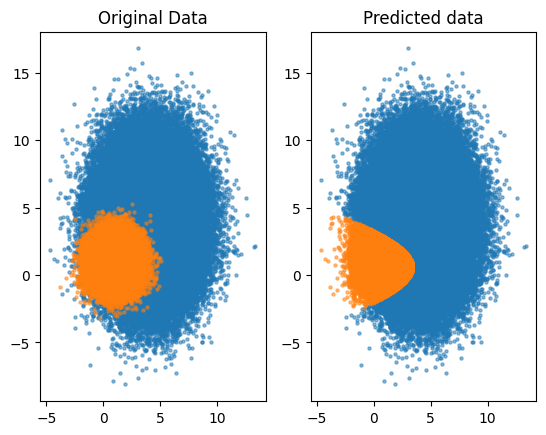

In [27]:
mlSetB = setB[setB[:,5].argsort()]
fig1 , axis1 = plt.subplots(1,2)
MLtempB = np.count_nonzero(mlSetB < 1, axis = 0)
MLzeroesB = MLtempB[5]

axis1[0].scatter(setB[60000:,0],setB[60000:,1], s=5, alpha = .5)
axis1[0].scatter(setB[:60000,0],setB[:60000,1], s=5, alpha = .5)
axis1[0].set_title("Original Data")

axis1[1].scatter(mlSetB[MLzeroesB:,0],mlSetB[MLzeroesB:,1], s=5, alpha = .5)
axis1[1].scatter(mlSetB[:MLzeroesB,0],mlSetB[:MLzeroesB,1], s=5, alpha = .5)
axis1[1].set_title("Predicted data")
plt.show()

In [28]:
for y in range(4):
    setA1Mean1, setA1Covariance1, setA2Mean1, setA2Covariance1 = parameterCalculations(setB,6*(10**(y)),14*(10**(y)))
    for x in range(setA.shape[0]):
        
        classifierValue = np.matrix([[setB[x][0],setB[x][1]]])
        value1 = discriminateValueCase3(classifierValue,setA1Mean1,setA1Covariance1, prior1)
        
        value2 = discriminateValueCase3(classifierValue,setA2Mean1,setA2Covariance1, prior2)
        
        classValue = 0

        if value1<value2:
            classValue = 1

        setB[x,6+y] = classValue

[1.36800002 0.69259168]
[[0.63903626 0.        ]
 [0.         0.28771797]]
[3.93060732 3.77078019]
[[2.32043857 0.        ]
 [0.         1.0058275 ]]

[0.99169192 1.00285643]
[[0.63903626 0.        ]
 [0.         0.27117453]]
[4.22813497 3.73164181]
[[1.0090865  0.        ]
 [0.         3.18196487]]

[1.04520625 1.01797823]
[[0.63903626 0.        ]
 [0.         0.23240886]]
[4.01213261 4.06245814]
[[0.75947903 0.        ]
 [0.         0.7775131 ]]

[1.00181687 1.01376155]
[[0.63903626 0.        ]
 [0.         0.17142097]]
[4.01440003 4.02546349]
[[1.01264534 0.        ]
 [0.         1.59056341]]



In [29]:
MLerror1, MLerror2, MLerror = missClassification(setB,6)
print(".01%")
print("class 1 misclassification ",MLerror1)
print("class 2 misclassification ",MLerror2)
print("total misclassification ",MLerror)
MLerror1, MLerror2, MLerror = missClassification(setB,7)
print(".1%")
print("class 1 misclassification ",MLerror1)
print("class 2 misclassification ",MLerror2)
print("total misclassification ",MLerror)
MLerror1, MLerror2, MLerror = missClassification(setB,8)
print("1%")
print("class 1 misclassification ",MLerror1)
print("class 2 misclassification ",MLerror2)
print("total misclassification ",MLerror)
MLerror1, MLerror2, MLerror = missClassification(setB,9)
print("10%")
print("class 1 misclassification ",MLerror1)
print("class 2 misclassification ",MLerror2)
print("total misclassification ",MLerror)

.01%
class 1 misclassification  0.14543680599649997
class 2 misclassification  0.10309461046009348
total misclassification  0.116765
.1%
class 1 misclassification  0.10601847412663407
class 2 misclassification  0.0670033327026909
total misclassification  0.07921
1%
class 1 misclassification  0.04506490325740877
class 2 misclassification  0.1328474538757055
total misclassification  0.10059
10%
class 1 misclassification  0.1328281337138733
class 2 misclassification  0.06519268668095574
total misclassification  0.08581


In [30]:
def loadImage(imagePath):
    img1 = cv2.imread(imagePath)
    
    return img1

    

In [31]:
#Creates an array of actual values for ML and the classifier array to find all skin values in the refenence image
def colorSeperation(original,ref):
    classifierArray = np.zeros((original.shape[0],original.shape[1]))
    skinValues = []
    for x in range(ref.shape[0]):
        for y in range(ref.shape[1]):
            colorSum = np.sum(ref[x][y])
            if(colorSum != 0):
                skinValues.append(original[x][y])
                classifierArray[x][y] = 1
    return np.array(skinValues),classifierArray

In [32]:
#chromaticColorspace transformation
#modular in case images are different sizes
def chromaticColorSpace(img1):
    for x in range(img1.shape[0]):
        for y in range(img1.shape[1]):
            rgb = np.sum(img1[x,y])
            #checks the pixel is black to avoid dividing by zero
            if(rgb == 0):
                img1[x,y] = [0,0,0]
            else:
                img1[x,y] /= rgb

    return img1

In [33]:
def yccColorSpace(img):
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            red = img[x][y][2]
            green = img[x][y][1]
            blue = img[x][y][0]

            img[x][y][0] = (.299*red) + (.587*green) + (.114*blue)
            img[x][y][1] = (-.169*red) - (.332*green) + (.5*blue)
            img[x][y][2] = (.5*red) - (.419*green) - (.081*blue)
    return img

In [34]:
#loads the 3 images and reference images into variables
img1 = loadImage(os.getcwd() + "/Training_1.ppm")
newimg1 = loadImage(os.getcwd() + "/ref1.ppm")
img2 = loadImage(os.getcwd() + "/Training_3.ppm")
newimg2 = loadImage(os.getcwd() + "/ref3.ppm")
img3 = loadImage(os.getcwd() + "/Training_6.ppm")
newimg3 = loadImage(os.getcwd() + "/ref6.ppm")

img1Y = loadImage(os.getcwd() + "/Training_1.ppm")
img2Y = loadImage(os.getcwd() + "/Training_3.ppm")
img3Y = loadImage(os.getcwd() + "/Training_6.ppm")

#changes the images to floats to apply the chromatic color space transformation
img1 = img1.astype(np.float32)
img2 = img2.astype(np.float32)
img3 = img3.astype(np.float32)

img1Y = img1Y.astype(np.float32)
img2Y = img2Y.astype(np.float32)
img3Y = img3Y.astype(np.float32)

#apply the YCbCr color space
img1Y = yccColorSpace(img1Y)
img2Y = yccColorSpace(img2Y)
img3Y = yccColorSpace(img3Y)



#chromatic space transformation on the data
img1 = chromaticColorSpace(img1)
img2 = chromaticColorSpace(img2)
img3 = chromaticColorSpace(img3)


testing1,actualArray1 = colorSeperation(img1,newimg1)
testing2,actualArray2 = colorSeperation(img2,newimg2)
testing3,actualArray3 = colorSeperation(img3,newimg3)

testing1Y,actualArray1Y = colorSeperation(img1Y,newimg1)
testing2Y,actualArray2Y = colorSeperation(img2Y,newimg2)
testing3Y,actualArray3Y = colorSeperation(img3Y,newimg3)


In [35]:
def imageML(set):

    rg = np.stack((set[:,2],set[:,1]),axis = 0)
    mean = np.mean(rg,axis = 1)
    cov = np.cov(rg)
    return mean,cov

In [36]:
#calculate the g(x) using the mean as new value
def calculateSkin(mean,cov,set,threshold,left):
    right = math.e**((-1/2 * (set - mean)*np.linalg.inv(cov)*(set-mean).transpose())[0,0])
    classifier = left * right

    if classifier>threshold:
        return 1
    else:
        return 0   
    

In [37]:
#creates the ML from the first image
skinMean1,skinCov1 = imageML(testing1)
skinMean2,skinCov2 = imageML(testing1Y)
skinMean1 = np.matrix([[skinMean1[0],skinMean1[1]]])
skinMean2 = np.matrix([[skinMean2[0],skinMean2[1]]])

#math to calculate the non mean values 
threshold1 = 1/(2 * math.pi * (np.linalg.det(skinCov1)**(1/2)))
bottom1 = (2 * math.pi) * np.linalg.det(skinCov1)**(1/2)
left1 = 1/bottom1
thresholds1 = np.zeros((21,1))
thresholdTemp1 = threshold1/20

threshold2 = 1/(2 * math.pi * (np.linalg.det(skinCov2)**(1/2)))
bottom2 = (2 * math.pi) * np.linalg.det(skinCov2)**(1/2)
left2 = 1/bottom2
thresholds2 = np.zeros((21,1))
thresholdTemp2 = threshold2/20

classifierArray1 = np.zeros((img1.shape[0],img1.shape[1],21))
classifierArray2 = np.zeros((img2.shape[0],img2.shape[1],21))
classifierArray3 = np.zeros((img3.shape[0],img3.shape[1],21))

classifierArray1Y = np.zeros((img1Y.shape[0],img1Y.shape[1],21))
classifierArray2Y = np.zeros((img2Y.shape[0],img2Y.shape[1],21))
classifierArray3Y = np.zeros((img3Y.shape[0],img3Y.shape[1],21))


for x in range(thresholds1.shape[0]):
    thresholds1[x] = thresholdTemp1*x
    thresholds2[x] = thresholdTemp2*x

rgValues1 = img1[:,:,[2,1]]
rgValues2 = img2[:,:,[2,1]]
rgValues3 = img3[:,:,[2,1]]

rgValues1Y = img1Y[:,:,[2,1]]
rgValues2Y = img2Y[:,:,[2,1]]
rgValues3Y = img3Y[:,:,[2,1]]

#loops through the arrays to classify the data
for x in range(img1.shape[0]):
    for y in range(img1.shape[1]):
        rgValue1 = rgValues1[x,y]
        rgValue2 = rgValues2[x,y]
        rgValue3 = rgValues3[x,y]

        rgValue1Y = rgValues1Y[x,y]
        rgValue2Y = rgValues2Y[x,y]
        rgValue3Y = rgValues3Y[x,y]
        for z in range(thresholds1.shape[0]):
            #finds the rg values from img and pass to calculate skin to classify
            classifierArray1[x][y][z] = calculateSkin(skinMean1,skinCov1,rgValue1,thresholds1[z],left1)
            classifierArray2[x][y][z] = calculateSkin(skinMean1,skinCov1,rgValue2,thresholds1[z],left1)
            classifierArray3[x][y][z] = calculateSkin(skinMean1,skinCov1,rgValue3,thresholds1[z],left1)

            classifierArray1Y[x][y][z] = calculateSkin(skinMean2,skinCov2,rgValue1Y,thresholds2[z],left2)
            classifierArray2Y[x][y][z] = calculateSkin(skinMean2,skinCov2,rgValue2Y,thresholds2[z],left2)
            classifierArray3Y[x][y][z] = calculateSkin(skinMean2,skinCov2,rgValue3Y,thresholds2[z],left2)

In [38]:
print(skinMean1)
print(skinMean2)
print(skinCov1)
print(skinCov2)

[[0.4322236  0.29577097]]
[[ 23.634272 -12.691341]]
[[ 0.00243325 -0.00111726]
 [-0.00111726  0.00078845]]
[[ 48.94583675 -21.74178397]
 [-21.74178397  31.19722207]]


In [39]:
#calculates the FAR and FRR of the data
def falseResults(classifierArray,actualArray1):
    far = 0
    frr = 0

    n = 0
    p = 0

    for x in range(actualArray1.shape[0]):
        for y in range(actualArray1.shape[1]):
            if actualArray1[x][y] == 0:
                n += 1
            else:
                p += 1
            
            if classifierArray[x][y] == 1 and actualArray1[x][y] == 0:
                far += 1
            elif classifierArray[x][y] == 0 and actualArray1[x][y] == 1:
                frr += 1
    

    return far/n,frr/p


In [40]:
#Prints the FAR and FRR of the data from figures using chromatic color space
FarFrr = np.zeros((21,2),dtype=np.float32)
FarFrr2 = np.zeros((21,2),dtype=np.float32)
FarFrr3 = np.zeros((21,2),dtype=np.float32)

FarFrrY = np.zeros((21,2),dtype=np.float32)
FarFrr2Y = np.zeros((21,2),dtype=np.float32)
FarFrr3Y = np.zeros((21,2),dtype=np.float32)

for x in range(classifierArray1.shape[2]):
    #print(falseResults(classifierArray[:,:,x],actualArray1))
    FarFrr[x][0],FarFrr[x][1] = falseResults(classifierArray1[:,:,x],actualArray1)
    FarFrr2[x][0],FarFrr2[x][1] = falseResults(classifierArray2[:,:,x],actualArray2)
    FarFrr3[x][0],FarFrr3[x][1] = falseResults(classifierArray3[:,:,x],actualArray3)

    FarFrrY[x][0],FarFrrY[x][1] = falseResults(classifierArray1Y[:,:,x],actualArray1Y)
    FarFrr2Y[x][0],FarFrr2Y[x][1] = falseResults(classifierArray2Y[:,:,x],actualArray2Y)
    FarFrr3Y[x][0],FarFrr3Y[x][1] = falseResults(classifierArray3Y[:,:,x],actualArray3Y)





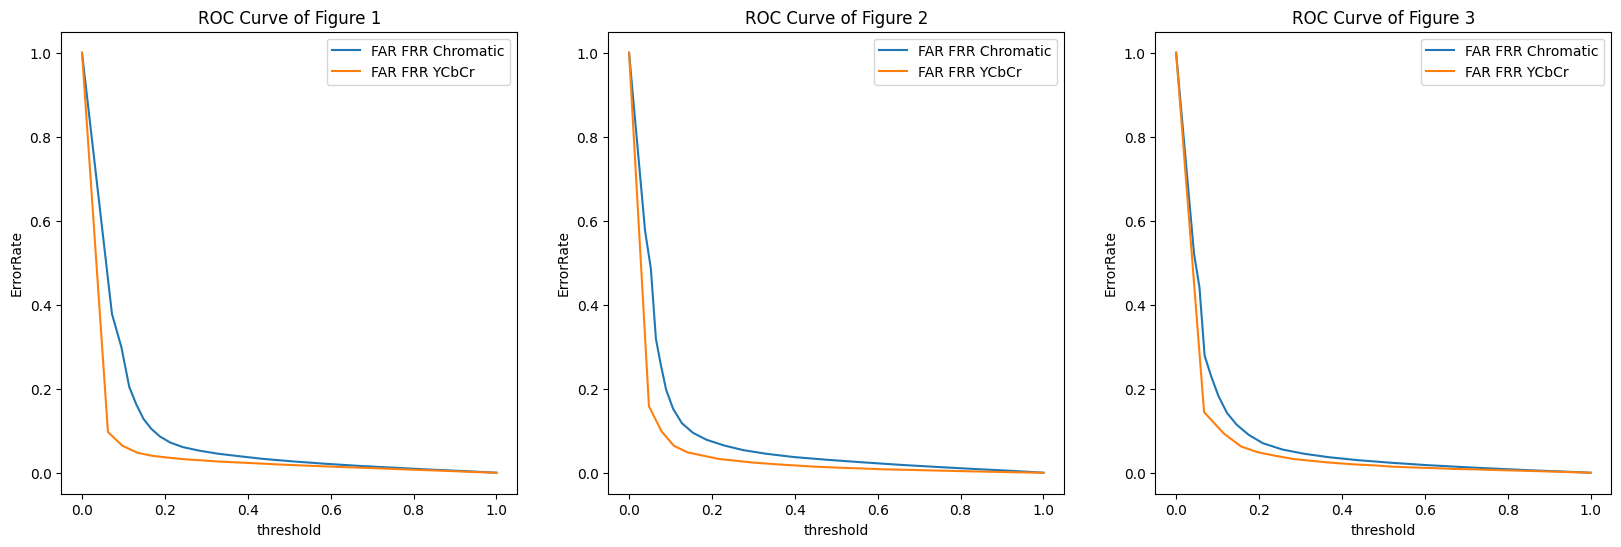

In [41]:
fig1 , axis4 = plt.subplots(1,3,figsize = (20,6))
axis4[0].plot(FarFrr[:,1],FarFrr[:,0], label = 'FAR FRR Chromatic')
#axis4[0].plot(thresholds1,FarFrr[:,1], label = 'FRR Line Chromatic')
axis4[0].plot(FarFrrY[:,1],FarFrrY[:,0], label = 'FAR FRR YCbCr' )
#axis4[0].plot(thresholds2,FarFrrY[:,1], label = 'FRR Line YCbCr', linewidth = .5 )
axis4[0].set_title('ROC Curve of Figure 1')
axis4[0].set_xlabel('threshold')
axis4[0].set_ylabel('ErrorRate')
axis4[0].legend()

axis4[1].plot(FarFrr2[:,1],FarFrr2[:,0], label = 'FAR FRR Chromatic')
#axis4[1].plot(thresholds1,FarFrr2[:,1], label = 'FRR Line Chromatic')
axis4[1].plot(FarFrr2Y[:,1],FarFrr2Y[:,0], label = 'FAR FRR YCbCr' )
#axis4[1].plot(thresholds2,FarFrr2Y[:,1], label = 'FRR Line YCbCr', linewidth = .5 )
axis4[1].set_title('ROC Curve of Figure 2')
axis4[1].set_xlabel('threshold')
axis4[1].set_ylabel('ErrorRate')
axis4[1].legend()

axis4[2].plot(FarFrr3[:,1],FarFrr3[:,0], label = 'FAR FRR Chromatic')
#axis4[2].plot(thresholds1,FarFrr3[:,1], label = 'FRR Line Chromatic')
axis4[2].plot(FarFrr3Y[:,1],FarFrr3Y[:,0], label = 'FAR FRR YCbCr')
#axis4[2].plot(thresholds2,FarFrr3Y[:,1], label = 'FRR Line YCbCr', linewidth = .5 )
axis4[2].set_title('ROC Curve of Figure 3')
axis4[2].set_xlabel('threshold')
axis4[2].set_ylabel('ErrorRate')
axis4[2].legend()



plt.show()


In [42]:
def interceptCalculator(thresholds1,lineDiff):
    values = np.polyfit(thresholds1,lineDiff,3)
    poly = np.poly1d(values)
    roots = np.roots(poly)
    intercept = np.real(roots[np.isreal(roots)])

    return intercept

In [43]:
#calculates the ERR of the FAR and FRR line for all figures
lineDiff = FarFrr[:,0] - FarFrr[:,1]
lineDiff2 = FarFrr2[:,0] - FarFrr2[:,1]
lineDiff3 = FarFrr3[:,0] - FarFrr3[:,1]

lineDiffY = FarFrrY[:,0] - FarFrrY[:,1]
lineDiff2Y = FarFrr2Y[:,0] - FarFrr2Y[:,1]
lineDiff3Y = FarFrr3Y[:,0] - FarFrr3Y[:,1]

#calculates the intercept points
intercept = interceptCalculator(thresholds1[:,0],lineDiff)
intercept2 = interceptCalculator(thresholds1[:,0],lineDiff2)
intercept3 = interceptCalculator(thresholds1[:,0],lineDiff3)

interceptY = interceptCalculator(thresholds2[:,0],lineDiffY)
intercept2Y = interceptCalculator(thresholds2[:,0],lineDiff2Y)
intercept3Y = interceptCalculator(thresholds2[:,0],lineDiff3Y)

finalClassifier = np.zeros((actualArray1.shape[0],actualArray1.shape[1]))
finalClassifier2 = np.zeros((actualArray1.shape[0],actualArray1.shape[1]))
finalClassifier3 = np.zeros((actualArray1.shape[0],actualArray1.shape[1]))

finalClassifierY = np.zeros((actualArray1Y.shape[0],actualArray1Y.shape[1]))
finalClassifier2Y = np.zeros((actualArray1Y.shape[0],actualArray1Y.shape[1]))
finalClassifier3Y = np.zeros((actualArray1Y.shape[0],actualArray1Y.shape[1]))

for x in range(img1.shape[0]):
    for y in range(img1.shape[1]):
            temp = np.matrix([[img1[x][y][2],img1[x][y][1]]])
            temp2 = np.matrix([[img2[x][y][2],img2[x][y][1]]])
            temp3 = np.matrix([[img3[x][y][2],img3[x][y][1]]])

            tempY = np.matrix([[img1Y[x][y][2],img1Y[x][y][1]]])
            temp2Y = np.matrix([[img2Y[x][y][2],img2Y[x][y][1]]])
            temp3Y = np.matrix([[img3Y[x][y][2],img3Y[x][y][1]]])
            #calculate g(x) with the ERR value from the ROC curve
            finalClassifier[x][y] = calculateSkin(skinMean1,skinCov1,temp,intercept,left1)
            finalClassifier2[x][y] = calculateSkin(skinMean1,skinCov1,temp2,intercept2,left1)
            finalClassifier3[x][y] = calculateSkin(skinMean1,skinCov1,temp3,intercept3,left1)

            finalClassifierY[x][y] = calculateSkin(skinMean2,skinCov2,tempY,interceptY,left2)
            finalClassifier2Y[x][y] = calculateSkin(skinMean2,skinCov2,temp2Y,intercept2Y,left2)
            finalClassifier3Y[x][y] = calculateSkin(skinMean2,skinCov2,temp3Y,intercept3Y,left2)




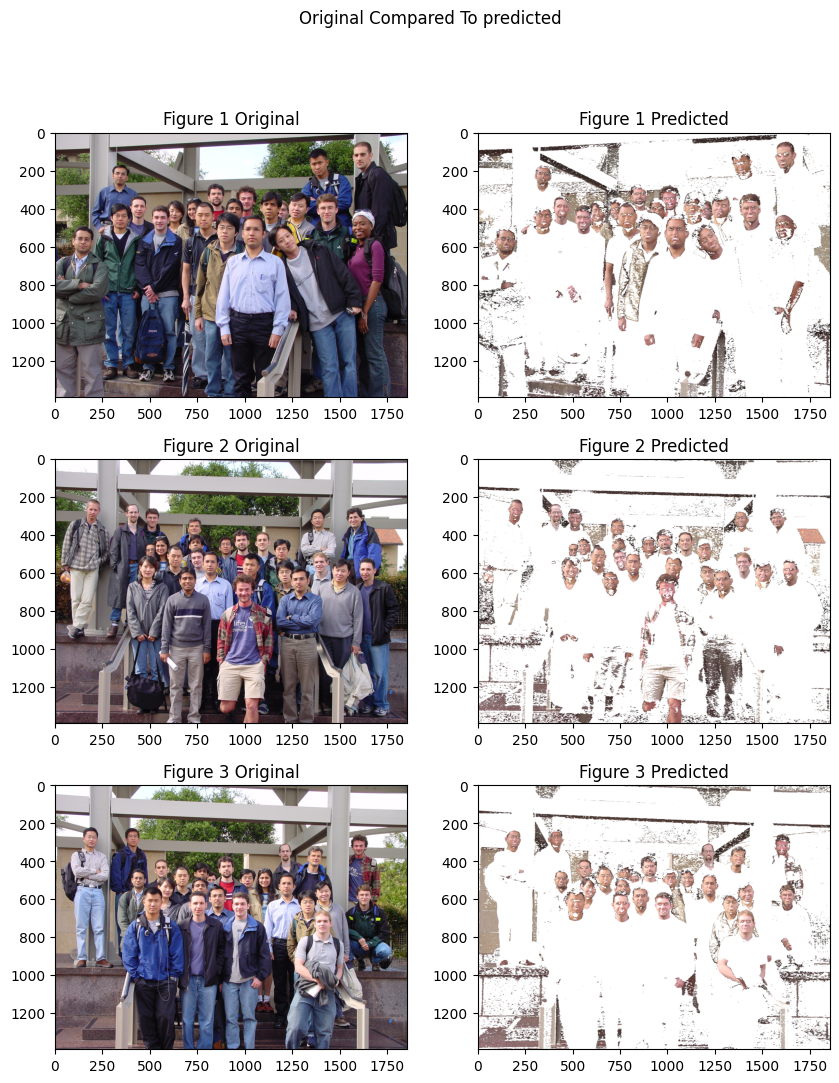

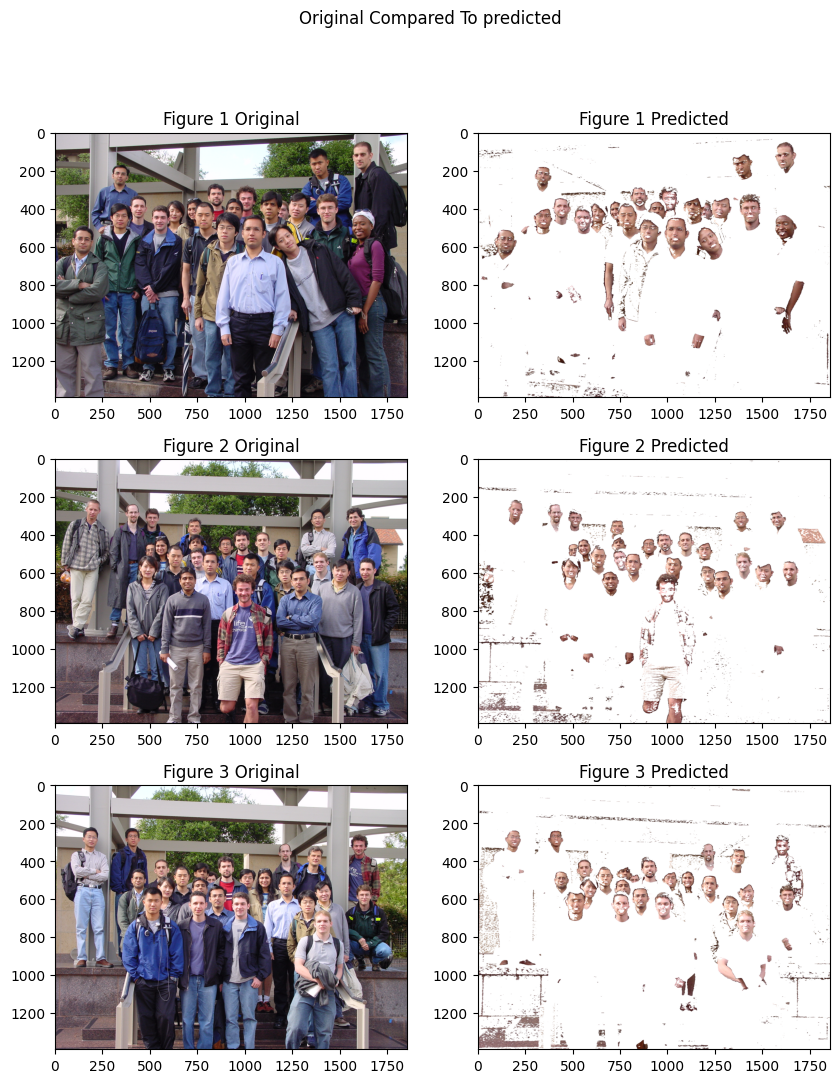

In [44]:
#reloads the images to apply new change and graph
img1 = loadImage(os.getcwd() + "/Training_1.ppm")
preApplied = loadImage(os.getcwd() + "./Training_1.ppm")
img2 = loadImage(os.getcwd() + "/Training_3.ppm")
preApplied2 = loadImage(os.getcwd() + "./Training_3.ppm")
img3 = loadImage(os.getcwd() + "/Training_6.ppm")
preApplied3 = loadImage(os.getcwd() + "./Training_6.ppm")

img1Y = loadImage(os.getcwd() + "/Training_1.ppm")
preAppliedY = loadImage(os.getcwd() + "./Training_1.ppm")
img2Y = loadImage(os.getcwd() + "/Training_3.ppm")
preApplied2Y = loadImage(os.getcwd() + "./Training_3.ppm")
img3Y = loadImage(os.getcwd() + "/Training_6.ppm")
preApplied3Y = loadImage(os.getcwd() + "./Training_6.ppm")

#changes the values of the image of non skin values to white
for x in range(img1.shape[0]):
    for y in range(img1.shape[1]):
        if finalClassifier[x][y] == 0:
            img1[x][y] = [255,255,255]
        if finalClassifier2[x][y] == 0:
            img2[x][y] = [255,255,255]
        if finalClassifier3[x][y] == 0:
            img3[x][y] = [255,255,255]
        if finalClassifierY[x][y] == 0:
            img1Y[x][y] = [255,255,255]
        if finalClassifier2Y[x][y] == 0:
            img2Y[x][y] = [255,255,255]
        if finalClassifier3Y[x][y] == 0:
            img3Y[x][y] = [255,255,255]
        

fig1 , colors = plt.subplots(3,2,figsize = (10,12))
fig1.suptitle('Original Compared To predicted')
colors[0,0].imshow(cv2.cvtColor(preApplied,cv2.COLOR_BGR2RGB))
colors[0,0].set_title('Figure 1 Original')
colors[0,1].imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))
colors[0,1].set_title('Figure 1 Predicted')

colors[1,0].imshow(cv2.cvtColor(preApplied2,cv2.COLOR_BGR2RGB))
colors[1,0].set_title('Figure 2 Original')
colors[1,1].imshow(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB))
colors[1,1].set_title('Figure 2 Predicted')

colors[2,0].imshow(cv2.cvtColor(preApplied3,cv2.COLOR_BGR2RGB))
colors[2,0].set_title('Figure 3 Original')
colors[2,1].imshow(cv2.cvtColor(img3,cv2.COLOR_BGR2RGB))
colors[2,1].set_title('Figure 3 Predicted')

fig2 , colorsY = plt.subplots(3,2,figsize = (10,12))
fig2.suptitle('Original Compared To predicted')
colorsY[0,0].imshow(cv2.cvtColor(preAppliedY,cv2.COLOR_BGR2RGB))
colorsY[0,0].set_title('Figure 1 Original')
colorsY[0,1].imshow(cv2.cvtColor(img1Y,cv2.COLOR_BGR2RGB))
colorsY[0,1].set_title('Figure 1 Predicted')

colorsY[1,0].imshow(cv2.cvtColor(preApplied2Y,cv2.COLOR_BGR2RGB))
colorsY[1,0].set_title('Figure 2 Original')
colorsY[1,1].imshow(cv2.cvtColor(img2Y,cv2.COLOR_BGR2RGB))
colorsY[1,1].set_title('Figure 2 Predicted')

colorsY[2,0].imshow(cv2.cvtColor(preApplied3Y,cv2.COLOR_BGR2RGB))
colorsY[2,0].set_title('Figure 3 Original')
colorsY[2,1].imshow(cv2.cvtColor(img3Y,cv2.COLOR_BGR2RGB))
colorsY[2,1].set_title('Figure 3 Predicted')

plt.show()
